# Bollinger Bands


## Yahoo finance
use yahoo_fin api to get data.


## 交易設定
* 投資人有總資金 1,000,000。
* 投資三間公司 Netfilx, Tesla, IGS。
* 每間公司各投資總資金的30%。
* 剩下10%留下來跑路。

## 盈虧比
* 凱力公式 (Kelly formula)
    * https://zh.wikipedia.org/wiki/%E5%87%B1%E5%88%A9%E5%85%AC%E5%BC%8F
* 勝率和盈虧比
    * https://www.chengxulvtu.com/%E9%87%8F%E5%8C%96%E7%AD%96%E7%95%A5%E4%B8%AD%E7%9A%84%E8%83%9C%E7%8E%87%E5%92%8C%E7%9B%88%E4%BA%8F%E6%AF%94/
* 有了勝率和盈虧比，就可以計算收支平衡點(BEP: Break-even point)的公式線
    
## Reference:
https://www.tradingview.com/u/Taiwan_Bear/


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from yahoo_fin.stock_info import get_data
import plotly.graph_objs as pltgo
%matplotlib inline

## 畫圖、取股票、布林通道設定

In [2]:
# interval format: "1d", "1wk", "1mo"
# date format: mm/dd/yyyy
def get_stock(ticker_list, start_date, end_date, days, N_std, interval="1d"):
    historical_datas = {}
    # Get ticker data
    for ticker in ticker_list:
        historical_datas[ticker] = get_data(ticker, start_date, end_date, interval=interval)

        # Calculate mean, std, upper bands, lower bands
        ticker_data = historical_datas[ticker]
        ticker_data['middle'] = ticker_data['close'].rolling(window=days).mean()
        ticker_data['std'] = ticker_data['close'].rolling(window=days).std()
        ticker_data['lower'] = ticker_data['middle'] - N_std * ticker_data['std']
        ticker_data['upper'] = ticker_data['middle'] + N_std * ticker_data['std']
        ticker_data['B'] = (ticker_data['close'] - ticker_data['lower']) / (ticker_data['upper'] - ticker_data['lower'])
        ticker_data['returns'] = ticker_data['adjclose'].pct_change()
        
    return historical_datas

In [3]:
# DF: Company's historical datas
def show_bollinger(DF, ticker, start_date, end_date, SIG=None):
    plt.figure(figsize=(20,10))
    plt.plot(DF['upper'], color='#CC99FF')
    plt.plot(DF['middle'], color="blue")
    plt.plot(DF['lower'], color='#CC99FF')
    plt.plot(DF['close'], color="black")
    if SIG is not None:
        plt.plot(DF['close'][SIG == 1], lw = 0, marker='^', markersize=10, c='g', alpha=0.7)
        plt.plot(DF['close'][SIG == 2], lw = 0, marker='v', markersize=10, c='r', alpha=0.7)
    plt.xlabel('date')
    plt.ylabel('price')
    plt.legend(['upper', 'middle', 'lower', 'close'])
    plt.grid(True)
    plt.title(f"{ticker} Bollinger band {start_date} ~ {end_date}")
    plt.show()

In [4]:
def bollinger_bands(DF, ticker):
    fig = pltgo.Figure()
    
    # Setup traces
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['upper'], line=dict(color='yellow', width=1.7), name = 'Upper Band'))
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['middle'], line=dict(color='blue', width=.7), name = 'Middle Band'))
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['lower'], line=dict(color='yellow', width=1.7), name = 'Lower Band'))
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['close'], line=dict(color='black', width=.7), name = 'Close price'))
    
    # candle stick
    fig.add_trace(pltgo.Candlestick(x=DF.index, open=DF['open'], high=DF['high'],
                                    low=DF['low'], close=DF['close'], name="market data"))
    fig.update_layout(title=ticker)
    fig.show()

In [5]:
# draw funding changes
def funding_changes(rec):
    rec= rec[rec['動作']=='SELL']
    plt.figure(figsize=(25, 10))
    plt.plot(rec['日期'], rec['總資金'],color="green")
    plt.title("IGS Funding changes (principal: 300000)")
    plt.show()

In [6]:
# 顯示回測
def show_returns(df):
    plt.hist(df['returns'].dropna(),bins=75,density=False)
    plt.show

In [7]:
def init_account(shares=0.0, cost=0.0, buy_times=0.0, earn=0.0,sell_times=0.0, capital=300000,per_trans=1000):
    account = {
        'shares': shares,     # 有幾股
        'cost': cost,
        'buy_times': buy_times,
        'earn': earn,
        'sell_times': sell_times,
        'capital': capital,  # 資金
        'per_trans': per_trans   # 一次買一張
    }
    return account

In [8]:
def init_rate(fee=0.001425, tax=0.003, slippage=1):
    rate = {
        'handling_fee': fee,
        'trans_tax': tax,
        'slippage': slippage
    }
    return rate

In [9]:
# Data Setup
IGS = "3293.two"
CSC = "2002.TW"
AT = "2458.TW"
ticker_list = ["tsla", "nflx", AT, CSC]

days = 20
N_std = 2

start_date = "10/01/2017"
end_date = "10/01/2020"

interval = "1d"

# fee tax or something else
rate = init_rate()

In [10]:
historical_datas = get_stock(ticker_list, start_date, end_date, days, N_std)

## 交易策略
### 進場
1. 當前價格由下往上穿過20日平均中線

### 出場
1. 當前價格由上往下穿過20日平均中線 (x)
* 停損
    1. 當前價格低於進場時的3%
* 停利
    2. 當前價格高於進場時的2%

In [11]:
def buy(investor, price, rate):
    b_price = investor['per_trans'] * (price + rate['slippage'])
    b_price += b_price * rate['handling_fee']
    investor['cost'] += b_price
    investor['buy_times'] += 1
    investor['shares'] += investor['per_trans']
    investor['capital'] -= b_price
    return investor, b_price

In [12]:
def sell(investor, price, rate):
    b_price = investor['shares'] * (price + rate['slippage'])
    b_price *= (1 - rate['handling_fee'])
    b_price *= (1 - rate['trans_tax'])
    investor['earn'] += b_price
    investor['sell_times'] += 1
    investor['shares'] = 0
    investor['capital'] += b_price
    return investor, b_price

In [13]:
def init_transc(strategy = 1):
    info = None
    if strategy == 1:
        info = {
            'close': 0,
            'pre_close': 0,
            'mean': 0,
            'stop_profit': 0,
            'stop_loss': 0,
            'have_day' : 0
        }
    return info

In [14]:
# 更新停損停利點
def update_info(info, company, day, investor):
    
    info['close'] = company['close'][day]
    info['mean'] = company['middle'][day]
    
    if investor['shares'] == 0:
        info['have_day'] = 0
    else:
        info['have_day'] += 1
    return info

In [15]:
def update_stop_point(info, raise_rate, drop_rate):
    info['stop_profit'] = info['close'] * (1 + raise_rate)
    info['stop_loss'] = info['close'] * (1 - drop_rate)
    return info

In [16]:
def simple_strategy(info, expiry_period = 60):
    
    if info['close'] > info['mean'] and info['pre_close'] < info['mean']:
        sign = "cross_up"
    elif info['close'] < info['mean'] and info['pre_close'] > info['mean']:
#         sign = "cross_dwn"
        sign = "None"
    elif info['close'] >= info['stop_profit']:
        sign = "stop_profit"
    elif info['close'] <= info['stop_loss']:
        sign = "stop_loss"
    elif info['have_day'] >= expiry_period:
        sign = "expiry_date"
    else:
        sign = "None"

    return sign, info['close']

In [17]:
# Return sign, price
def trade(info, strategy = 1):
    if strategy == 1:
        return simple_strategy(info)

In [18]:
# return company dataframe, transaction record, investor final
def transaction(company, strategy=1, drop_rate=0.03, raise_rate=0.02, print_earn=False):
    # Investor capital
    investor = init_account()
    SIG = np.zeros(len(company))

    record = []
    
    # Initial trading info
    info = init_transc()
    
    for day in range(0, len(company)):
        
        
        info = update_info(info, company, day, investor)
        
        BUY = ["cross_up"]
        SELL = ["cross_dwn", "stop_loss", "stop_profit", "expiry_date"]
        
        sign, price = trade(info)

        if sign in BUY and investor['shares'] == 0:
            info = update_stop_point(info, raise_rate, drop_rate)
            investor, actuall_price = buy(investor, price, rate)
            record.append([company.index[day], 'BUY', sign, investor['capital'],
                           investor['shares'], price, actuall_price, day])
            SIG[day] = 1
        elif sign in SELL and investor['shares'] != 0:
            investor, actuall_price = sell(investor, price, rate)
            record.append([company.index[day], 'SELL', sign, investor['capital'],
                           investor['shares'], price, actuall_price, day])
            SIG[day] = 2
        
        info['pre_close'] = info['close']
        
    # 清空
    if investor['shares'] != 0:
        investor, actuall_price = sell(investor, price, rate)
        record.append([company.index[day], 'SELL', 'clean', investor['capital'],
                           investor['shares'], info['close'], actuall_price, day])
        SIG[day] = 2
    total_earn = investor['earn'] - investor['cost']
    if print_earn:
        print(f"Total Earn: {total_earn}")
    record = pd.DataFrame(record, columns=['日期', '動作', '指標', '總資金', '持有股', '交易每股金額', '實際買賣金額', 'Index'])
    return record, investor, SIG, total_earn

## CSC

In [19]:
CSC_df = historical_datas[CSC]
CSC_df

open       high        low      close   adjclose    volume  \
2017-10-02  24.450001  24.549999  24.400000  24.500000  22.137461   5422410   
2017-10-03  24.500000  24.549999  24.350000  24.450001  22.092283   8301039   
2017-10-05  24.350000  24.650000  24.350000  24.650000  22.272997   7638161   
2017-10-06  24.600000  24.650000  24.500000  24.600000  22.227819   6051573   
2017-10-11  24.350000  24.549999  24.299999  24.450001  22.092283  17936423   
...               ...        ...        ...        ...        ...       ...   
2020-09-24  20.350000  20.400000  20.000000  20.000000  20.000000  28253718   
2020-09-25  20.150000  20.200001  20.000000  20.150000  20.150000  11078662   
2020-09-28  20.200001  20.450001  20.200001  20.450001  20.450001   9284160   
2020-09-29  20.500000  20.750000  20.500000  20.600000  20.600000  21250797   
2020-09-30  20.700001  20.700001  20.450001  20.450001  20.450001  15561179   

             ticker   middle       std      lower      upper         B  \
2017-10-02  2002.TW      NaN       NaN        NaN        NaN       NaN   
2017-10-03  2002.TW      NaN       NaN        NaN        NaN       NaN   
2017-10-05  2002.TW      NaN       NaN        NaN        NaN       NaN   
2017-10-06  2002.TW      NaN       NaN        NaN        NaN       NaN   
2017-10-11  2002.TW      NaN       NaN        NaN        NaN       NaN   
...             ...      ...       ...        ...        ...       ...   
2020-09-24  2002.TW  20.5625  0.428853  19.704795  21.420205  0.172090   
2020-09-25  2002.TW  20.5700  0.419712  19.730576  21.409424  0.249828   
2020-09-28  2002.TW  20.5975  0.390504  19.816492  21.378508  0.405571   
2020-09-29  2002.TW  20.6275  0.364358  19.898784  21.356216  0.481131   
2020-09-30  2002.TW  20.6450  0.345612  19.953777  21.336224  0.358946   

             returns  
2017-10-02       NaN  
2017-10-03 -0.002041  
2017-10-05  0.008180  
2017-10-06 -0.002028  
2017-10-11 -0.006098  
...              ...  
2020-09-24 -0.026764  
2020-09-25  0.007500  
2020-09-28  0.014888  
2020-09-29  0.007335  
2020-09-30 -0.007282  

[730 rows x 13 columns]

In [20]:
# 策略1
CSC_rec, CSC_iv, CSC_sig, CSC_earn = transaction(historical_datas[CSC], print_earn=True)

Total Earn: -1267.6385933833662


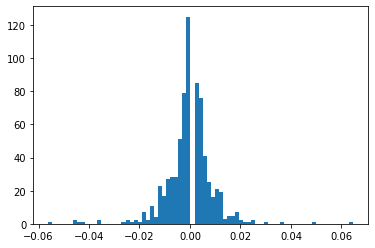

In [21]:
show_returns(CSC_df) # 回測

In [22]:
CSC_iv

{'shares': 0,
 'cost': 438874.5081600666,
 'buy_times': 18.0,
 'earn': 437606.86956668325,
 'sell_times': 18.0,
 'capital': 298732.36140661663,
 'per_trans': 1000}

In [23]:
CSC_rec

日期    動作           指標            總資金     持有股     交易每股金額  \
0  2017-11-03   BUY     cross_up  274263.376736  1000.0  24.700001   
1  2018-01-08  SELL  stop_profit  300397.332705     0.0  25.250000   
2  2018-01-25   BUY     cross_up  274260.139823  1000.0  25.100000   
3  2018-02-06  SELL    stop_loss  298751.390367     0.0  23.600000   
4  2018-04-09   BUY     cross_up  273916.051132  1000.0  23.799999   
5  2018-06-05  SELL  stop_profit  299104.206029     0.0  24.299999   
6  2018-06-20   BUY     cross_up  274268.866793  1000.0  23.799999   
7  2018-07-24  SELL  stop_profit  299905.033125     0.0  24.750000   
8  2018-08-14   BUY     cross_up  273918.053611  1000.0  24.950001   
9  2018-08-23  SELL  stop_profit  300300.904398     0.0  25.500000   
10 2018-09-18   BUY     cross_up  274263.854398  1000.0  25.000000   
11 2018-09-28  SELL  stop_profit  300646.705186     0.0  25.500000   
12 2018-11-05   BUY     cross_up  275260.581054  1000.0  24.350000   
13 2019-01-09  SELL  stop_profit  301095.864000     0.0  24.950001   
14 2019-02-20   BUY     cross_up  274858.528235  1000.0  25.200001   
15 2019-05-14  SELL    stop_loss  299847.568418     0.0  24.100000   
16 2019-06-06   BUY     cross_up  274461.444286  1000.0  24.350000   
17 2019-06-19  SELL  stop_profit  300296.727232     0.0  24.950001   
18 2019-07-03   BUY     cross_up  274560.103968  1000.0  24.700001   
19 2019-08-01  SELL    stop_loss  299250.469228     0.0  23.799999   
20 2019-09-02   BUY     cross_up  275015.983464  1000.0  23.200001   
21 2019-11-05  SELL  stop_profit  299706.348724     0.0  23.799999   
22 2019-11-26   BUY     cross_up  275121.365738  1000.0  23.549999   
23 2020-01-03  SELL  stop_profit  300110.405921     0.0  24.100000   
24 2020-01-10   BUY     cross_up  275224.994289  1000.0  23.850000   
25 2020-01-31  SELL    stop_loss  299218.455196     0.0  23.100000   
26 2020-02-19   BUY     cross_up  274683.542696  1000.0  23.500000   
27 2020-03-09  SELL    stop_loss  297980.097351     0.0  22.400000   
28 2020-04-27   BUY     cross_up  277450.884851  1000.0  19.500000   
29 2020-04-30  SELL  stop_profit  298358.049626     0.0  20.000000   
30 2020-05-05   BUY     cross_up  277528.410390  1000.0  19.799999   
31 2020-06-02  SELL  stop_profit  298833.806495     0.0  20.400000   
32 2020-06-16   BUY     cross_up  277002.742259  1000.0  20.799999   
33 2020-07-24  SELL    stop_loss  298059.243546     0.0  20.150000   
34 2020-08-26   BUY     cross_up  276929.175664  1000.0  20.100000   
35 2020-09-08  SELL  stop_profit  298732.361407     0.0  20.900000   

          實際買賣金額  Index  
0   25736.623264     21  
1   26133.955969     66  
2   26137.192882     79  
3   24491.250545     87  
4   24835.339236    121  
5   25188.154898    161  
6   24835.339236    171  
7   25636.166331    195  
8   25986.979514    210  
9   26382.850787    217  
10  26037.050000    235  
11  26382.850787    242  
12  25386.124132    267  
13  25835.282946    312  
14  26237.335764    335  
15  24989.040182    389  
16  25386.124132    406  
17  25835.282946    414  
18  25736.623264    424  
19  24690.365260    445  
20  24234.485764    466  
21  24690.365260    507  
22  24584.982986    522  
23  24989.040182    549  
24  24885.411632    554  
25  23993.460907    562  
26  24534.912500    575  
27  23296.554655    587  
28  20529.212500    620  
29  20907.164775    623  
30  20829.639236    625  
31  21305.396105    645  
32  21831.064236    655  
33  21056.501286    681  
34  21130.067882    704  
35  21803.185743    713

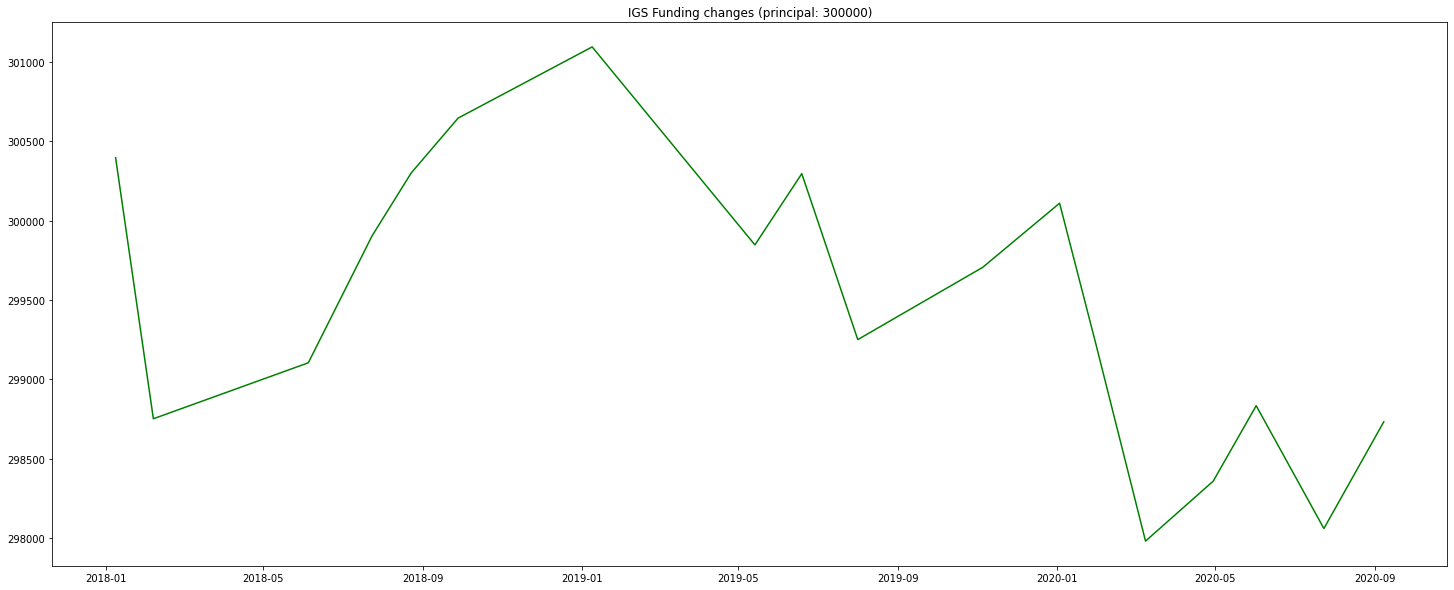

In [24]:
funding_changes(CSC_rec)

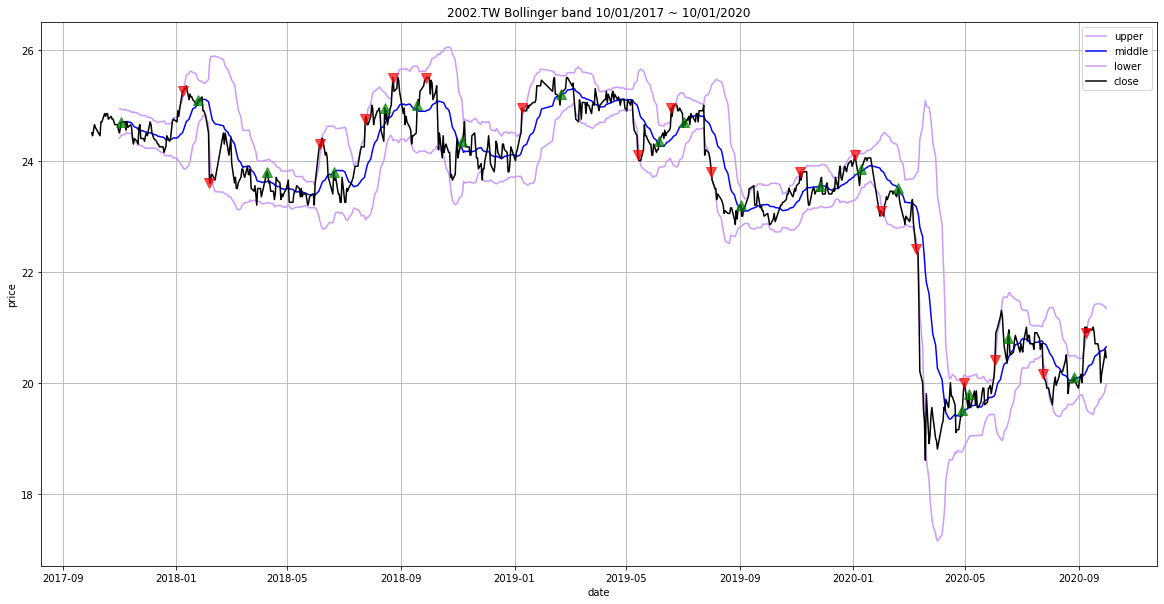

In [25]:
# 策略1
show_bollinger(CSC_df, CSC, start_date, end_date, CSC_sig)

In [26]:
bollinger_bands(historical_datas[CSC], CSC)

## Compare Companys

In [69]:
# return company dataframe, transaction record, investor final
def compareCompanys(ticker_list, raise_rate=0.02, drop_rate=0.03):
    results= []
    companys = get_stock(ticker_list, start_date, end_date, days, N_std)
    
    for ticker, company in companys.items():
        rec, iv, sig, earn = transaction(company, print_earn=True)
        results.append([ticker, iv['earn']-iv['cost'], iv['earn'],
                            iv['cost'], iv['buy_times'], iv['sell_times']])

    return pd.DataFrame(results, columns=['公司', '獲利', '收入', '花費', '買(次數)', '賣(次數)'])

In [70]:
compareCompanys(ticker_list)

Total Earn: 62934.28302444797
Total Earn: -50514.30120595731
Total Earn: -244.13682086858898
Total Earn: -1267.6385933833662


公司            獲利            收入            花費  買(次數)  賣(次數)
0     tsla  62934.283024  3.141100e+06  3.078166e+06   31.0   31.0
1     nflx -50514.301206  1.025398e+07  1.030449e+07   31.0   31.0
2  2458.TW   -244.136821  2.767952e+06  2.768196e+06   34.0   34.0
3  2002.TW  -1267.638593  4.376069e+05  4.388745e+05   18.0   18.0

## 盈虧比

In [29]:
CSC_rec

日期    動作           指標            總資金     持有股     交易每股金額  \
0  2017-11-03   BUY     cross_up  274263.376736  1000.0  24.700001   
1  2018-01-08  SELL  stop_profit  300397.332705     0.0  25.250000   
2  2018-01-25   BUY     cross_up  274260.139823  1000.0  25.100000   
3  2018-02-06  SELL    stop_loss  298751.390367     0.0  23.600000   
4  2018-04-09   BUY     cross_up  273916.051132  1000.0  23.799999   
5  2018-06-05  SELL  stop_profit  299104.206029     0.0  24.299999   
6  2018-06-20   BUY     cross_up  274268.866793  1000.0  23.799999   
7  2018-07-24  SELL  stop_profit  299905.033125     0.0  24.750000   
8  2018-08-14   BUY     cross_up  273918.053611  1000.0  24.950001   
9  2018-08-23  SELL  stop_profit  300300.904398     0.0  25.500000   
10 2018-09-18   BUY     cross_up  274263.854398  1000.0  25.000000   
11 2018-09-28  SELL  stop_profit  300646.705186     0.0  25.500000   
12 2018-11-05   BUY     cross_up  275260.581054  1000.0  24.350000   
13 2019-01-09  SELL  stop_profit  301095.864000     0.0  24.950001   
14 2019-02-20   BUY     cross_up  274858.528235  1000.0  25.200001   
15 2019-05-14  SELL    stop_loss  299847.568418     0.0  24.100000   
16 2019-06-06   BUY     cross_up  274461.444286  1000.0  24.350000   
17 2019-06-19  SELL  stop_profit  300296.727232     0.0  24.950001   
18 2019-07-03   BUY     cross_up  274560.103968  1000.0  24.700001   
19 2019-08-01  SELL    stop_loss  299250.469228     0.0  23.799999   
20 2019-09-02   BUY     cross_up  275015.983464  1000.0  23.200001   
21 2019-11-05  SELL  stop_profit  299706.348724     0.0  23.799999   
22 2019-11-26   BUY     cross_up  275121.365738  1000.0  23.549999   
23 2020-01-03  SELL  stop_profit  300110.405921     0.0  24.100000   
24 2020-01-10   BUY     cross_up  275224.994289  1000.0  23.850000   
25 2020-01-31  SELL    stop_loss  299218.455196     0.0  23.100000   
26 2020-02-19   BUY     cross_up  274683.542696  1000.0  23.500000   
27 2020-03-09  SELL    stop_loss  297980.097351     0.0  22.400000   
28 2020-04-27   BUY     cross_up  277450.884851  1000.0  19.500000   
29 2020-04-30  SELL  stop_profit  298358.049626     0.0  20.000000   
30 2020-05-05   BUY     cross_up  277528.410390  1000.0  19.799999   
31 2020-06-02  SELL  stop_profit  298833.806495     0.0  20.400000   
32 2020-06-16   BUY     cross_up  277002.742259  1000.0  20.799999   
33 2020-07-24  SELL    stop_loss  298059.243546     0.0  20.150000   
34 2020-08-26   BUY     cross_up  276929.175664  1000.0  20.100000   
35 2020-09-08  SELL  stop_profit  298732.361407     0.0  20.900000   

          實際買賣金額  Index  
0   25736.623264     21  
1   26133.955969     66  
2   26137.192882     79  
3   24491.250545     87  
4   24835.339236    121  
5   25188.154898    161  
6   24835.339236    171  
7   25636.166331    195  
8   25986.979514    210  
9   26382.850787    217  
10  26037.050000    235  
11  26382.850787    242  
12  25386.124132    267  
13  25835.282946    312  
14  26237.335764    335  
15  24989.040182    389  
16  25386.124132    406  
17  25835.282946    414  
18  25736.623264    424  
19  24690.365260    445  
20  24234.485764    466  
21  24690.365260    507  
22  24584.982986    522  
23  24989.040182    549  
24  24885.411632    554  
25  23993.460907    562  
26  24534.912500    575  
27  23296.554655    587  
28  20529.212500    620  
29  20907.164775    623  
30  20829.639236    625  
31  21305.396105    645  
32  21831.064236    655  
33  21056.501286    681  
34  21130.067882    704  
35  21803.185743    713

In [73]:
def profit_loss_analysis(df_rec, print_info=False):

    list_buy = (df_rec[df_rec['動作'] == 'BUY']['實際買賣金額'])
    list_sell = (df_rec[df_rec['動作'] == 'SELL']['實際買賣金額'])
#     print(list_buy, len(list_buy))
#     print(list_sell, len(list_sell))
    
    list_buy = list(list_buy)
    list_sell = list(list_sell)
    
    total_win = 0.0
    total_loss = 0.0
    win_times = 0
    loss_times = 0

    for i in range(len(list_sell)):
        gain = list_sell[i] - list_buy[i]
        if gain > 0:
            total_win += gain
            win_times += 1
        elif gain <= 0:
            total_loss += gain
            loss_times += 1

    win_rate = win_times / (win_times + loss_times)
    PL_ratio = abs((total_win) / (total_loss))
    BEP_pw = 1 / (PL_ratio + 1)
    
    if print_info:
        print('-------------------------\n')
        print('total win: ' + str(total_win) + ' （盈利金額）')
        print('total loss: '+ str(total_loss) + ' （虧損金額）')
        print('\n-------------------------\n')
        print('win times: ', win_times)
        print('loss times: ', loss_times)
        print('win rate: ' + str(win_rate * 100)[:5] + '%')
        print('\n-------------------------\n')
        print('profit loss ratio: ' + str(PL_ratio)[:5] + '% ' + ' （ |total win / total loss| 即盈虧比 ）')
        print('\nexpected value: ' + str(PL_ratio * win_rate - (1 - win_rate)) + ' （ 期望值 ＝（盈虧比 x 勝率）–（1 - 勝率））')
        print('\n-------------------------')
    
    return PL_ratio, win_rate, BEP_pw

In [74]:
pl = profit_loss_analysis(CSC_rec, True)
pl

-------------------------

total win: 5577.7288482033255 （盈利金額）
total loss: -6845.367441586637 （虧損金額）

-------------------------

win times:  12
loss times:  6
win rate: 66.66%

-------------------------

profit loss ratio: 0.814%  （ |total win / total loss| 即盈虧比 ）

expected value: 0.20987869005811455 （ 期望值 ＝（盈虧比 x 勝率）–（1 - 勝率））

-------------------------


(0.814818035087172, 0.6666666666666666, 0.5510194304146677)

In [75]:
def draw_PL_BEP_Figure(tickler):
    # Draw Break-out point line
    raise_ratios = np.arange(0.001, 0.01, 0.001)
    drop_ratios = np.arange(0.01, 0.1, 0.01)
    
    company = historical_datas[tickler].copy()
    PL_ratios = []
    win_rates = []
    BEP_pws = []
    hpr = []
    # cnts
    buy_cnts = []
    sell_cnts = []
    raise_r = []
    drop_r = []
    
    for r in range(2,5,1):
        for d in drop_ratios:
            rec, iv, _, total_earn = transaction(company, drop_rate=d, raise_rate=d*r)
            PL_ratio, win_rate, BEP_pw = profit_loss_analysis(rec)
#             print(PL_ratio, win_rate, BEP_pw)
            
            PL_ratios.append(PL_ratio)
            win_rates.append(win_rate)
            BEP_pws.append(BEP_pw)
            
            hpr.append(round(total_earn / 300000 * 100, 2))
            buy_cnts.append(iv['buy_times'])
            sell_cnts.append(iv['sell_times'])
            
            raise_r.append(d*r)
            drop_r.append(d)
    
    
    # Sort BEP and PL
    sorted_BEPs = []
    sorted_PLs = []
    for s_bep, s_pl in  sorted(zip(BEP_pws, PL_ratios), key=lambda x : x[1]):
        sorted_BEPs.append(s_bep)
        sorted_PLs.append(s_pl)

    plt.figure(figsize=(25, 10))
    plt.plot(sorted_BEPs, sorted_PLs, '-', c='g')
    plt.plot(win_rates, PL_ratios, 'o', color = 'red')
    plt.xlabel('pw')
    plt.ylabel('w/l')
    plt.title('w/l and win_rate relation')
    plt.show()
    
    # 3D
#     raise_r = np.repeat(raise_ratios, 10)
#     drop_r = np.tile(drop_ratios, 10)
    df = pd.DataFrame(list(zip(raise_r, drop_r, buy_cnts, sell_cnts, PL_ratios, win_rates, hpr)),columns=['停利點','停損點','進場次數','出場次數','W/L','Pw','投資報酬率(%)'])
    figure = plt.figure(figsize=(12, 8))
    axes = figure.add_subplot(111,projection = "3d")
    xpos = win_rates
    ypos = PL_ratios
    zpos = np.zeros(len(hpr))
    dx = np.ones(len(win_rates))
    for i in range(len(dx)):
        dx[i] = 0.01
    dy = np.ones(len(PL_ratios))
    for i in range(len(dy)):
        dy[i] = 0.05
    dz = hpr
    axes.bar3d(xpos, ypos, zpos, dx, dy, dz, color='red')
    axes.set_xlabel('Pw')
    axes.set_ylabel('W/L')
    axes.set_zlabel('hpr%')

    plt.show()
    return df

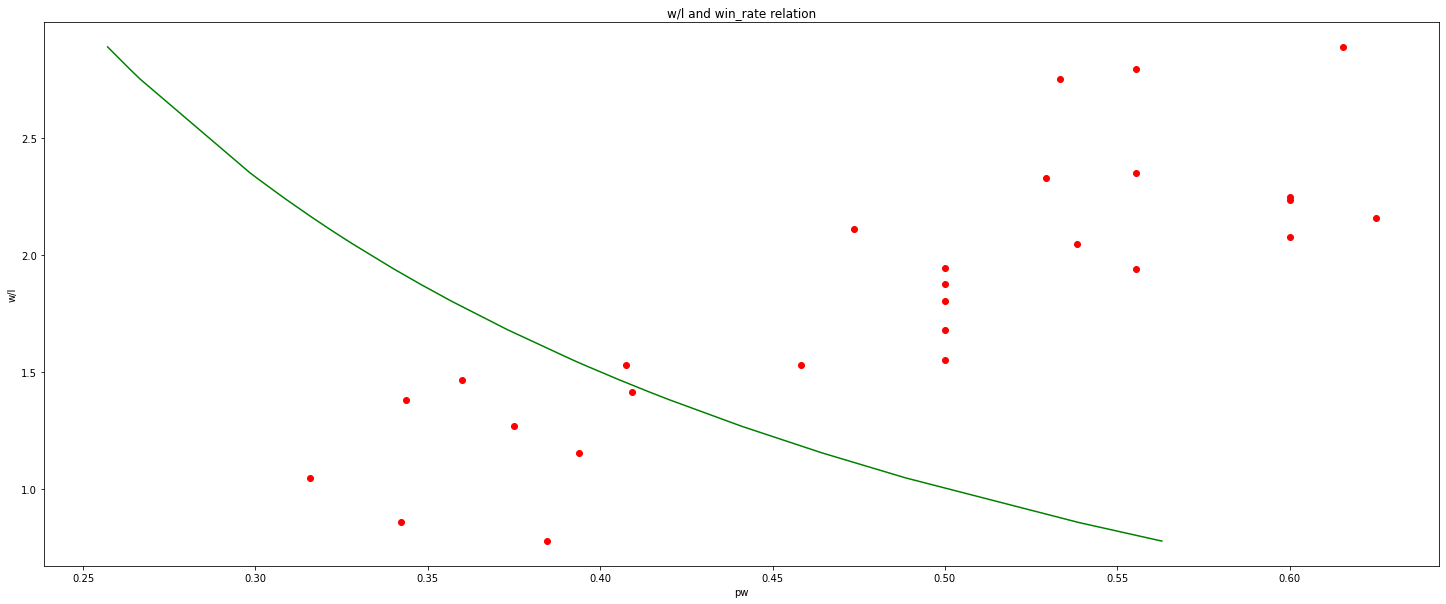

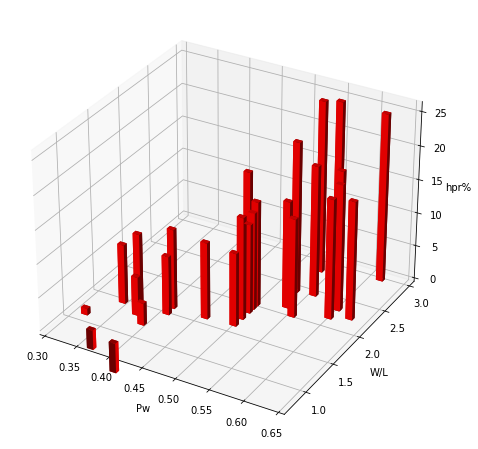

In [76]:
df = draw_PL_BEP_Figure(AT)

In [77]:
df

停利點   停損點  進場次數  出場次數       W/L        Pw  投資報酬率(%)
0   0.02  0.01  39.0  39.0  0.776374  0.384615     -4.51
1   0.04  0.02  33.0  33.0  1.153675  0.393939      3.34
2   0.06  0.03  28.0  28.0  1.550471  0.500000     10.91
3   0.08  0.04  24.0  24.0  1.527566  0.458333     11.43
4   0.10  0.05  24.0  24.0  1.680282  0.500000     15.22
5   0.12  0.06  18.0  18.0  1.939519  0.555556     14.69
6   0.14  0.07  16.0  16.0  2.157739  0.625000     17.63
7   0.16  0.08  15.0  15.0  2.077786  0.600000     17.83
8   0.18  0.09  15.0  15.0  2.249061  0.600000     20.70
9   0.03  0.01  38.0  38.0  0.856197  0.342105     -2.95
10  0.06  0.02  32.0  32.0  1.266912  0.375000      5.80
11  0.09  0.03  27.0  27.0  1.528385  0.407407     11.92
12  0.12  0.04  22.0  22.0  1.414611  0.409091      8.79
13  0.15  0.05  18.0  18.0  2.351758  0.555556     19.48
14  0.18  0.06  17.0  17.0  2.328053  0.529412     22.44
15  0.21  0.07  15.0  15.0  2.235595  0.600000     18.82
16  0.24  0.08  13.0  13.0  2.889431  0.615385     25.04
17  0.27  0.09  12.0  12.0  1.801807  0.500000     13.29
18  0.04  0.01  38.0  38.0  1.046361  0.315789      0.99
19  0.08  0.02  32.0  32.0  1.380957  0.343750      8.88
20  0.12  0.03  25.0  25.0  1.466804  0.360000     10.31
21  0.16  0.04  19.0  19.0  2.110145  0.473684     18.09
22  0.20  0.05  18.0  18.0  2.796096  0.555556     25.89
23  0.24  0.06  15.0  15.0  2.752331  0.533333     25.69
24  0.28  0.07  13.0  13.0  2.048096  0.538462     15.96
25  0.32  0.08  12.0  12.0  1.874587  0.500000     14.47
26  0.36  0.09  12.0  12.0  1.942006  0.500000     15.61